# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [3]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10086,16040,60992,Dreamland,21-03-2020,Idea for anyone who had planned on proposing: ...,Extremely Positive
25600,35153,80105,Edinburgh and Moraira,06-04-2020,Tired of doing your bit to keep Covid-19 at ba...,Extremely Negative
18982,26906,71858,Crawley,25-03-2020,@iamthemunchie Nice to see you back Munchie on...,Negative
33343,44822,89774,United States,14-04-2020,Remember back in the day when youÃÂd go to t...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
df["Sentiment"].value_counts()

Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [5]:
df["Sentiment"] = df["Sentiment"].apply(lambda s: 1 if s == "Positive" or s == "Extremely Positive" else 0)

Сбалансированы ли классы?

In [6]:
df["Sentiment"].value_counts()

1    18046
0    15398
Name: Sentiment, dtype: int64

In [7]:
l = list(df["Sentiment"].value_counts())
print("0:", l[0] / (l[0] + l[1]))
print("1:", l[1] / (l[0] + l[1]))

0: 0.5395885659610095
1: 0.46041143403899054


**Ответ:** Да, сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [8]:
df[df.isna().any(axis=1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
11,3813,48765,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,1
16,3821,48773,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,1
17,3822,48774,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,1
...,...,...,...,...,...,...
33431,44938,89890,NaN,14-04-2020,Hello everyone \r\r\nPlease share this in your...,1
33437,44947,89899,NaN,14-04-2020,UV light Sterilizer Sanitizer for your mask an...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0


In [9]:
df = df.fillna("Unknown")

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [11]:
wordlist = " ".join(train["OriginalTweet"]).lower().split()

In [12]:
from collections import Counter
wordlist_dictionary = Counter(wordlist)

Какой размер словаря получился?

In [13]:
len(wordlist_dictionary)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [14]:
sorted(wordlist_dictionary.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Наиболее часто встречаются артикли, союзы и глаголы to be в разных формах, а также токен #coronavirus. Артикли и предлоги чаще остальных слов встречаются в английском языке, так как слов, принадлежащих к остальным частям речи, очень много, а предлогов и артиклей (которые встречаются перед многими словами) - ограниченное количество. Глагол to be - один из самых частых английских глаголов. Так как база данных твитов собрана во время коронавируса, то также ожидаемо, что хештег #coronavirus будет встречаться во многих твитах.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [15]:
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

# del wordlist_distionary[stopwords.words("english")]
# map(wordlist_dictionary.__delitem__, )
for key in stopwords.words("english"):
    del wordlist_dictionary[key]
sorted(wordlist_dictionary.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  Удалились все слова по типу предлогов/союзов/глаголов to be/и т. д. (т. е. все несмысловые слова). Остались слова с лексическим значением. Самые популярные слова соответствуют часто обсуждаемым в интернете темам

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [16]:
sorted(wordlist_dictionary.items(), key=lambda kv: kv[1])[:20]

[('https://t.co/1m881cwfuv', 1),
 ('happy..', 1),
 ('https://t.co/z0intks34x', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('brink.', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('teaching.)', 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@@ballardspahrll', 1),
 ('#aca', 1),
 ('easier...take', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('husted:', 1),
 ('irishman', 1),
 ('#happystpatricksday!', 1)]

**Ответ:** Здесь все редкие слова встречаются по одному разу. Это редкие хештеги, ссылки, слова с опечатками/связанными с ними знаками препинания. Вероятно, такие слова лучше не учитывать в обучении.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [17]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tokenizer_list = tw.tokenize(" ".join(train["OriginalTweet"]))
tokenizer_dictionary = Counter(tokenizer_list)
sorted(tokenizer_dictionary.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('the', 24337),
 ('.', 24108),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** Отличается наличием знаков препинания как отдельных слов, а также токенайзер различает большие и маленькие буквы:

In [18]:
tokenizer_dictionary["the"], tokenizer_dictionary["The"]

(24337, 2516)

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [19]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)
for key in noise:
    del tokenizer_dictionary[key]
sorted(tokenizer_dictionary.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('Â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691)]

**Ответ:** Да, есть какие-то странные символы, которые не отображаются нормально в текущей кодировке

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [20]:
tokenizer_dictionary_without_symbols = dict()
for c in tokenizer_dictionary.keys():
    if (len(c) != 1 or ord(c) < 128):
        tokenizer_dictionary_without_symbols[c] = tokenizer_dictionary[c]
tokenizer_dictionary = tokenizer_dictionary_without_symbols
sorted(tokenizer_dictionary.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691),
 ('supermarket', 3373),
 ('grocery', 3083),
 ('people', 3047)]

In [21]:
sorted(tokenizer_dictionary.items(), key=lambda kv: kv[1])[:20]

[('https://t.co/1m881CwFUv', 1),
 ('https://t.co/Z0intkS34x', 1),
 ('MnuchinÃ', 1),
 ('https://t.co/JmoBv8z0U0', 1),
 ("University's", 1),
 ('@CatholicPres', 1),
 ('@CatholicUniv', 1),
 ('https://t.co/EvQby035wF', 1),
 ('https://t.co/rIQrhxxeIM', 1),
 ('@BallardSpahrLL', 1),
 ('#training', 1),
 ('#aca', 1),
 ('https://t.co/0FmSmlGePM', 1),
 ('Irishman', 1),
 ('#HappyStPatricksDay', 1),
 ('Guiness', 1),
 ('https://t.co/18V0PYHwb7', 1),
 ('https://t.co/LS0g86i8PU', 1),
 ('https://t.co/oFVkejfF23', 1),
 ('https://t.co/Xoodgd2uLx', 1)]

**Ответ:** Слова считаются лучше: теперь подсчёт не включает, например, различные знаки препинания, идущие сразу после слов. Однако теперь подсчёт учитывает регистр букв: the и The считаются разными словами (что может быть полезно, но не всегда).

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [22]:
hashtags = dict((k, v) for k, v in tokenizer_dictionary.items() if k[0] == "#")
sorted(hashtags.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('#coronavirus', 7143),
 ('#COVID19', 1844),
 ('#Covid_19', 1463),
 ('#Coronavirus', 1281),
 ('#COVID2019', 927),
 ('#toiletpaper', 657),
 ('#covid19', 568),
 ('#COVID', 542),
 ('#CoronaCrisis', 426),
 ('#CoronaVirus', 351)]

**Ответ:** В датасете с твитами про коронавирус чаще всего встречаются теги про коронавирус

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [23]:
links = dict((k, v) for k, v in tokenizer_dictionary.items() if k[:12] == "https://t.co")
sorted(links.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/DefTruI1PfÃ\x82Â', 3),
 ('https://t.co/WrLHYzIzAA', 3),
 ('https://t.co/kuwIpF1KQW', 3),
 ('https://t.co/zjNRx6dKKN', 3),
 ('https://t.co/3GBBDpdjat', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/G63RP042HO', 3)]

In [24]:
print("hashtags number:", len(hashtags))
print("links number:", len(links))

hashtags number: 11069
links number: 12797


**Ответ:** Популярность сравнима (т. е. общее число хештегов и общее число ссылок не сильно отличаются), однако по выводу топа словарей это не так заметно, так как ссылки, маскирующие сайты (https://t.co) практически всегда разные, и это различие не несёт информации о самой ссылке и материалах, которые она показывает

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [25]:
def custom_tokenizer(text):
  tokens = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(tokens)
  noise = stopwords.words("english") + list(punctuation)
  tokens = [k for k in tokens if k not in noise]
  tokens = [k for k in tokens if len(k) != 1 or ord(k) < 128]
  tokens = [k for k in tokens if k[:12] != "https://t.co"]
  return tokens


In [26]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
train_cv = cv.fit_transform(train["OriginalTweet"])
print(len(cv.vocabulary_))

c:\Users\extra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Словарь более чем в 2 раза меньше, потому что из него удалены стоп-слова, ссылки и т. п.

Посмотрим на какой-нибудь конкретный твитт:

In [28]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [29]:
dictionary = dict()
words = custom_tokenizer(train.iloc[ind]['OriginalTweet'])

for w in words:
    dictionary[w] = cv.vocabulary_[w]

print("Most important:", max(dictionary))
print("Least important:", min(dictionary))

Most important: show
Least important: #coronavirusoutbreak


**Ответ:** Плохо. Чисто интуитивно в твите можно выделить и более важные слова, чем show, однако даже на уровне этих двух примеров кажется, что хештег позволяет скорее судить о настроении твита, чем слово show

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
train_tv = tv.fit_transform(train["OriginalTweet"])
dictionary = dict()
words = custom_tokenizer(train.iloc[ind]['OriginalTweet'])

for w in words:
    dictionary[w] = tv.vocabulary_[w]

print("Most important:", max(dictionary))
print("Least important:", min(dictionary))

Most important: show
Least important: #coronavirusoutbreak


**Ответ:** Определились так же, как и в предыдущем задании

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [31]:
train[train['OriginalTweet'].apply(lambda x: 'wow' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21153,29594,74546,Canada,01-04-2020,"""Record stores are tactile, physical spaces, c...",1
3845,8467,53419,"Cincinnati, Ohio",18-03-2020,Never in all my days have I seen the grocery s...,1
31039,41987,86939,Canada,11-04-2020,After learning that toilet paper sales went up...,1
31162,42133,87085,Unknown,11-04-2020,Wow..just..wow...so many haven't had a paychec...,1
13179,19788,64740,Unknown,22-03-2020,Received an email from ?@SouthwestAir? and tho...,1
31635,42711,87663,"New York, NY",12-04-2020,"Quarantine shopping: wow, bread making machine...",1
11382,17603,62555,"Greenwich, London",21-03-2020,Back in Blighty and wow how things have change...,1
23203,32145,77097,"England, United Kingdom",04-04-2020,Due to #COVID2019 some bus drivers Don't wear ...,1


In [32]:
tweet = train.loc[3845]['OriginalTweet']
words = custom_tokenizer(tweet)
print(tweet)

for w in words:
    dictionary[w] = tv.vocabulary_[w]

print("Most important:", max(dictionary))
print("Least important:", min(dictionary))

Never in all my days have I seen the grocery store packed at 7:00 am in the morning. Just wow! #coronavirus #COVID19 #CoronaVirusUpdate
Most important: wow
Least important: #coronavirus


**Ответ:** Слово wow хорошо показывает положительную окраску твита, а хештег о коронавирусе, который, напротив, чаще будет говорить о негативной окраске, в данном случае как раз помечен как неважный

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [33]:
y_train = train["Sentiment"]
y_test = test["Sentiment"]

test_cv = cv.transform(test["OriginalTweet"])
test_tv = tv.transform(test["OriginalTweet"])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression(max_iter=1000, random_state=1337)
lr_cv.fit(train_cv, y_train)

print("CV train accuracy:", accuracy_score(y_train, lr_cv.predict(train_cv)))
print("CV test accuracy:", accuracy_score(y_test, lr_cv.predict(test_cv)))

print()

lr_tv = LogisticRegression(max_iter=1000, random_state=1337)
lr_tv.fit(train_tv, y_train)

print("TV train accuracy:", accuracy_score(y_train, lr_tv.predict(train_tv)))
print("TV test accuracy:", accuracy_score(y_test, lr_tv.predict(test_tv)))

CV train accuracy: 0.9844510892780863
CV test accuracy: 0.8672513454255532

TV train accuracy: 0.9254592054677488
TV test accuracy: 0.8531991229818616


**Ответ:** Результат CV лучше

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [35]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  tokens = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(tokens)
  noise = stopwords.words("english") + list(punctuation)
  tokens = [k for k in tokens if k not in noise]
  tokens = [k for k in tokens if len(k) != 1 or ord(k) < 128]
  tokens = [k for k in tokens if k[:12] != "https://t.co"]
  stemmer = SnowballStemmer("english")
  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [36]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [37]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
train_cv = cv.fit_transform(train["OriginalTweet"])

print(len(cv.vocabulary_))

c:\Users\extra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [38]:
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
train_tv = tv.fit_transform(train["OriginalTweet"])
print(len(tv.vocabulary_))

36652


**Ответ** Размер словаря ещё сильнее уменьшился, так как теперь разные формы слова учитываются как одно

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [39]:
test_cv = cv.transform(test["OriginalTweet"])
test_tv = tv.transform(test["OriginalTweet"])
lr_cv = LogisticRegression(max_iter=1000, random_state=1337)
lr_cv.fit(train_cv, y_train)

print("CV train accuracy:", accuracy_score(y_train, lr_cv.predict(train_cv)))
print("CV test accuracy:", accuracy_score(y_test, lr_cv.predict(test_cv)))

print()

lr_tv = LogisticRegression(max_iter=1000, random_state=1337)
lr_tv.fit(train_tv, y_train)

print("TV train accuracy:", accuracy_score(y_train, lr_tv.predict(train_tv)))
print("TV test accuracy:", accuracy_score(y_test, lr_tv.predict(test_tv)))

CV train accuracy: 0.9718923536950022
CV test accuracy: 0.8672513454255532

TV train accuracy: 0.9158906450234943
TV test accuracy: 0.8560892963922663


**Ответ:** Стемминг сделал хуже трейн и незначительно лучше тест. Смысла применять, наверное, нет.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [40]:
words = Counter(custom_stem_tokenizer(" ".join(train["OriginalTweet"]))).items()

In [41]:
sorted(words, key=lambda kv: kv[1], reverse=True)[:10]

[('#coronavirus', 8809),
 ('19', 7167),
 ('covid', 6253),
 ('price', 5283),
 ('store', 4671),
 ('food', 4463),
 ('supermarket', 4193),
 ('groceri', 3760),
 ('peopl', 3501),
 ('shop', 2796)]

In [42]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            train["OriginalTweet"]
                            )
print(len(cv_df.vocabulary_))

c:\Users\extra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** отсекаем хештег #coronavirus

In [43]:
sorted(words, key=lambda kv: kv[1], reverse=True)[3700]

('bandana', 11)

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [44]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train["OriginalTweet"]
                            )
print(len(cv_df.vocabulary_))

c:\Users\extra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [46]:
train_cv_df = cv_df.transform(train["OriginalTweet"])
test_cv_df = cv_df.transform(test["OriginalTweet"])
lr_cv = LogisticRegression(max_iter=1000, random_state=1337)
lr_cv.fit(train_cv_df, y_train)

print("CV train accuracy:", accuracy_score(y_train, lr_cv.predict(train_cv_df)))
print("CV test accuracy:", accuracy_score(y_test, lr_cv.predict(test_cv_df)))

CV train accuracy: 0.9286629645450662
CV test accuracy: 0.8680486346422165


**Ответ:** Качество на трейне уменьшилось, на тесте незначительно возросло

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
train_cv_df = scaler.fit_transform(train_cv_df)
test_cv_df = scaler.transform(test_cv_df)

lr_cv = LogisticRegression(max_iter=1000, random_state=1337)
lr_cv.fit(train_cv_df, y_train)

print("CV train accuracy:", accuracy_score(y_train, lr_cv.predict(train_cv_df)))
print("CV test accuracy:", accuracy_score(y_test, lr_cv.predict(test_cv_df)))

CV train accuracy: 0.9416915847928236
CV test accuracy: 0.8447279250548136


<Axes: xlabel='token'>

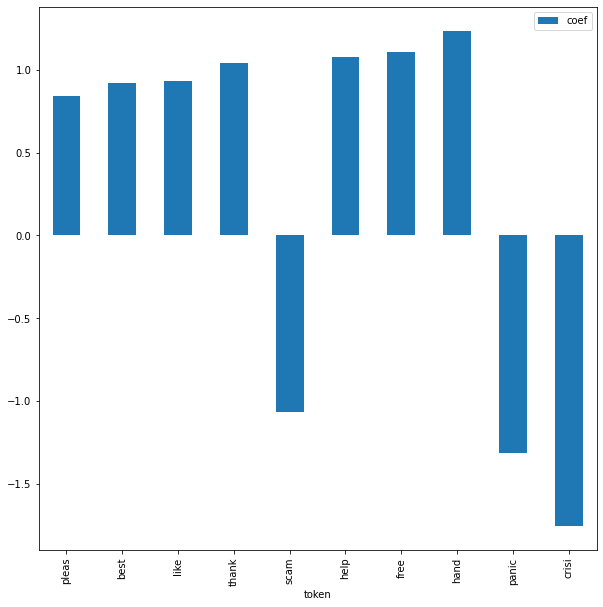

In [59]:
tokens = pd.DataFrame({"token" : cv_df.get_feature_names_out(), "coef" : lr_cv.coef_[0]}).sort_values(by="coef", key=abs)
plt.rcParams["figure.figsize"] = (10, 10)
tokens[-10:].plot.bar(x="token", y="coef")

**Ответ:** В целом слова с положительной эмоциональной окраской отмечены как положительные, а с отрицательной - как отрицательные. Вроде всё работает как надо.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [61]:
train.corr()

,UserName,ScreenName,Sentiment
UserName,1.000000,1.000000,0.054568
ScreenName,1.000000,1.000000,0.054568
Sentiment,0.054568,0.054568,1.000000


**Ответ:** Нет, они бесполезны, так как имя пользователя очень слабо влияет на настроение твита (да и вообще они числами для анонимности заменены)

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [67]:
import datetime
train["TweetAt"] = train["TweetAt"].apply(lambda s: datetime.datetime.strptime(s, "%d-%m-%Y").date())

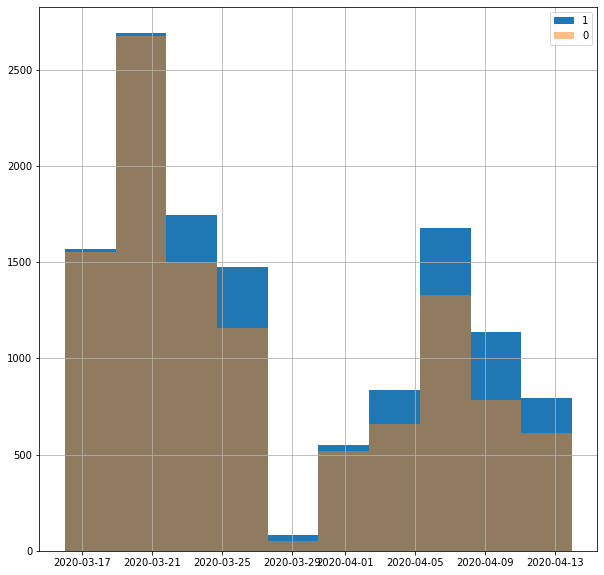

In [76]:
train["TweetAt"][train["Sentiment"] == 1].hist()
train["TweetAt"][train["Sentiment"] == 0].hist(alpha=0.5)
plt.legend(["1", "0"])

**Ответ:** Очень с натяжечкой, но можно сказать, что положительных твитов определённые отрезки времени больше, чем отрицательных (хотя если классифицировать только на основе этого признака - будет очень плохо), поэтому может быть и полезен



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [77]:
train["Location"].value_counts()

Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: Location, Length: 7949, dtype: int64

7949 уникальных значений (включая Unknown)

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<Axes: >

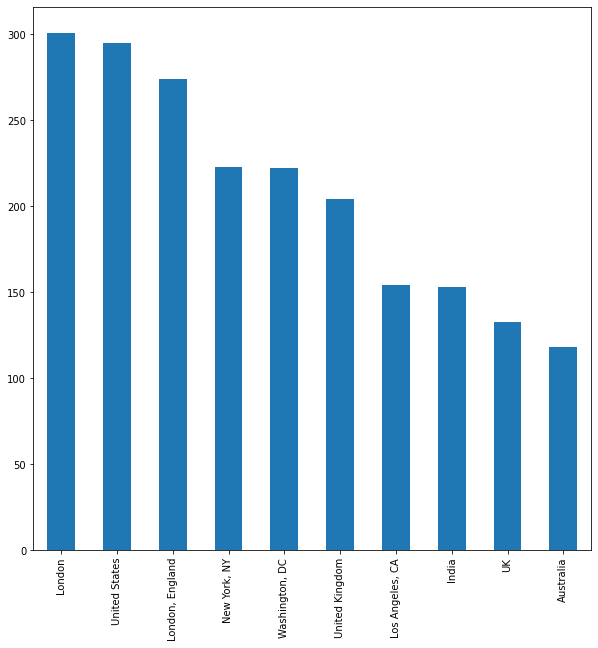

In [84]:
train["Location"].value_counts()[1:11].plot(kind='bar')

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [90]:
train["WiderLocation"] = train["Location"].apply(lambda s: s.split(", ")[-1])
train["WiderLocation"].value_counts()

Unknown                    4944
USA                         950
England                     860
CA                          597
India                       535
                           ... 
The DC & The OC               1
UK - Europe                   1
not Drumpf's Reich USSR       1
iowa                          1
NIGERIA                       1
Name: WiderLocation, Length: 4921, dtype: int64

Теперь 4921 уникальных значений

<Axes: >

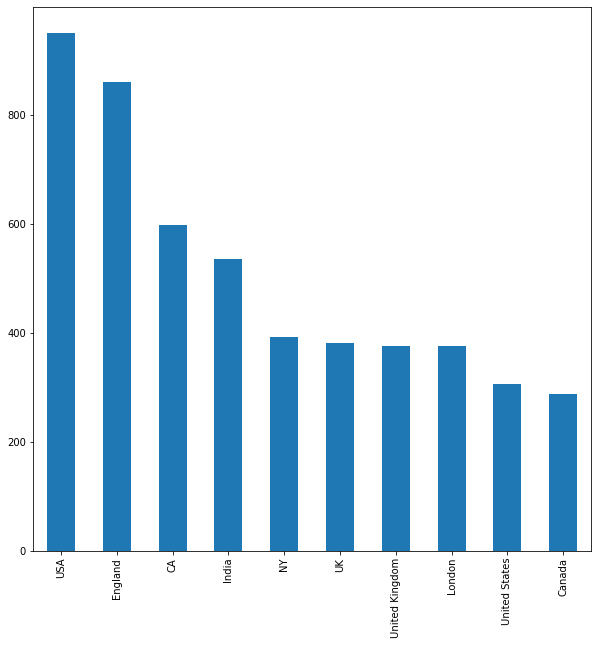

In [91]:
train["WiderLocation"].value_counts()[1:11].plot(kind='bar')

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --